# **NEURAL NETWORK**
## MNIST Classifier

## Problem

Write an MNIST classifier that trains to 99% accuracy or above.
You should stop training once you reach that level of accuracy.

Hint: It should succeed in less than 10 epochs.

## Initialize

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

## Dataset

Load the MNIST dataset from `tf.keras`.

In [3]:
# load dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# check shapes
print("shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

shapes:
x_train: (60000, 28, 28)
y_train: (60000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


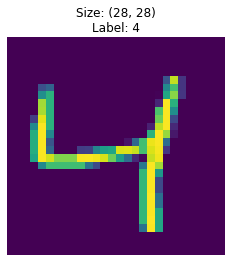

In [4]:
# check one image
idx = 2

# plot
plt.figure()
plt.title(f"Size: {x_train[idx].shape}\nLabel: {y_train[idx]}")
plt.axis('off')
plt.imshow(x_train[idx])
plt.show()

**Normalization**
- It allows the NN model to learn all optimal parameters more quickly.

In [5]:
# normalize
x_train = x_train / 255.
x_test = x_test / 255.

## Model

**Note**

- Use `'softmax'` activation function in the output layer since the problem is multi-class classification.
- Use `'sparse_categorical_crossentropy'` loss since labels are of ordinal category.
- Alternatively, you can convert labels to one-hot-encoding, then use `'categorical_crossentropy'` loss.

In [6]:
# input layer
input_tensor = Input(shape=x_train.shape[1:])

# hidden layers
x = Flatten()(input_tensor)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# output layer with 'softmax' activation function
output_tensor = Dense(10, activation='softmax')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'sparse_categorical_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).

**Note**:
- Use `log.get()` to get desired metric to monitor.
- The parameter name in `log.get()` should match the metric defined in `model.compile()`.

In [7]:
# create a custom class of callback
# to check accuracy after end of each epoch
class MonitorAccuracy(tf.keras.callbacks.Callback):

    def __init__(self, stop_accuracy=0.99):
        # initiate
        super(MonitorAccuracy, self).__init__()
        self.stop_accuracy = stop_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # at the end of the epoch,
        # if accuracy is greater than the given 'stop_accuracy':
        print(f"Epoch {epoch+1} - loss: {logs.get('loss'):.4f} - acc: {logs.get('acc'):.4f}")
        if logs.get('acc') > self.stop_accuracy:
            # print the termination message
            print(f"\nAccuracy reached to {self.stop_accuracy}. So, cancelling training...")
            # stop training
            self.model.stop_training = True


monitor_acc = MonitorAccuracy(0.99)

## Training

In [8]:
# train the model and save the history
hist = model.fit(
    x_train, y_train,
    epochs=10,
    verbose=0,
    callbacks=[monitor_acc]
)

Epoch 1 - loss: 0.2071 - acc: 0.9388
Epoch 2 - loss: 0.0838 - acc: 0.9739
Epoch 3 - loss: 0.0568 - acc: 0.9821
Epoch 4 - loss: 0.0436 - acc: 0.9861
Epoch 5 - loss: 0.0332 - acc: 0.9898
Epoch 6 - loss: 0.0275 - acc: 0.9912

Accuracy reached to 0.99. So, cancelling training...


<Figure size 432x288 with 0 Axes>

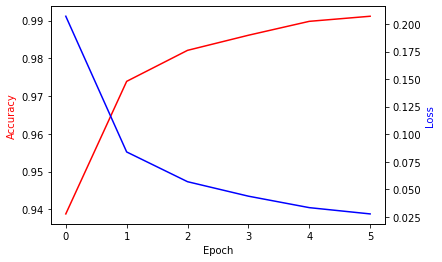

In [9]:
# plot the loss and accuracy
plt.figure()
_, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(hist.history['acc'], label='Accuracy', color='r')
ax2.plot(hist.history['loss'], label='Loss', color='b')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='r')
ax2.set_ylabel('Loss', color='b')

plt.show()

## Evauation

In [10]:
# test
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

**Confusion matrix**

<Figure size 432x288 with 0 Axes>

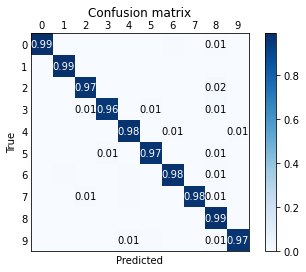

In [11]:
# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

# show the confusion matrix
plt.figure()
fig, ax = plt.subplots()

cax = ax.matshow(conf_mat, cmap='Blues')
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

fig.colorbar(cax)

plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

labels = list(range(10))
plt.xticks(labels, labels)
plt.yticks(labels, labels)
ax.tick_params(axis='both', which='both', length=0)

plt.show()